# Bias and Variance: Decision Boundary Stability Across Datasets

## Objective
Understand bias and variance through the lens of **decision boundary stability**:

- **High Bias, Low Variance**: Boundaries are **stable** (consistent across datasets) but **wrong** (don't capture true pattern)
- **Low Bias, High Variance**: Boundaries are **unstable** (change dramatically across datasets) but can be accurate on average
- **Optimal**: Boundaries are **relatively stable AND accurate**

## Key Insight
Instead of thinking about bias/variance as abstract statistical properties, we'll visualize them as:
- **Variance** = How much the decision boundary **wobbles** when you change the training data
- **Bias** = How far the **average** decision boundary is from the true boundary

## Approach
1. Generate multiple training datasets from the same distribution
2. Train models of varying complexity on each dataset
3. Visualize how decision boundaries change
4. Quantify boundary stability and accuracy

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from matplotlib.patches import Patch
import warnings
warnings.filterwarnings('ignore')

# Set style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")
np.random.seed(42)

print("✓ Libraries imported successfully")

✓ Libraries imported successfully


## Part 1: Synthetic Dataset with Known True Boundary

We'll create a 2D binary classification problem where:
- **True boundary**: A known, relatively simple curve (e.g., circular or sinusoidal)
- **Observed data**: Points sampled from two classes with some noise
- **Multiple datasets**: We'll generate many different training sets from the same distribution

This allows us to:
1. Know the ground truth decision boundary
2. See how learned boundaries vary across different samples
3. Measure both bias (distance from truth) and variance (instability)

In [2]:
def generate_classification_data(n_samples=200, noise=0.15, random_state=None):
    """
    Generate 2D classification data with a non-linear true boundary.
    True boundary: A circular pattern with some irregularity
    """
    if random_state is not None:
        np.random.seed(random_state)
    
    # Generate points uniformly in 2D space
    X = np.random.randn(n_samples, 2)
    
    # True decision boundary: circular with sinusoidal perturbation
    # Formula: r_boundary = 1.5 + 0.3*sin(4*theta)
    distances = np.sqrt(X[:, 0]**2 + X[:, 1]**2)
    angles = np.arctan2(X[:, 1], X[:, 0])
    true_boundary_radius = 1.5 + 0.3 * np.sin(4 * angles)
    
    # Assign labels based on distance from center (with noise)
    y_true = (distances < true_boundary_radius).astype(int)
    
    # Add noise: flip some labels
    n_flip = int(noise * n_samples)
    flip_indices = np.random.choice(n_samples, n_flip, replace=False)
    y_noisy = y_true.copy()
    y_noisy[flip_indices] = 1 - y_noisy[flip_indices]
    
    return X, y_noisy, y_true

# Generate a single dataset for visualization
X_example, y_example, y_true_example = generate_classification_data(
    n_samples=300, noise=0.15, random_state=42
)

print(f"Generated {len(X_example)} samples")
print(f"Class 0: {np.sum(y_example == 0)} samples")
print(f"Class 1: {np.sum(y_example == 1)} samples")

Generated 300 samples
Class 0: 117 samples
Class 1: 183 samples


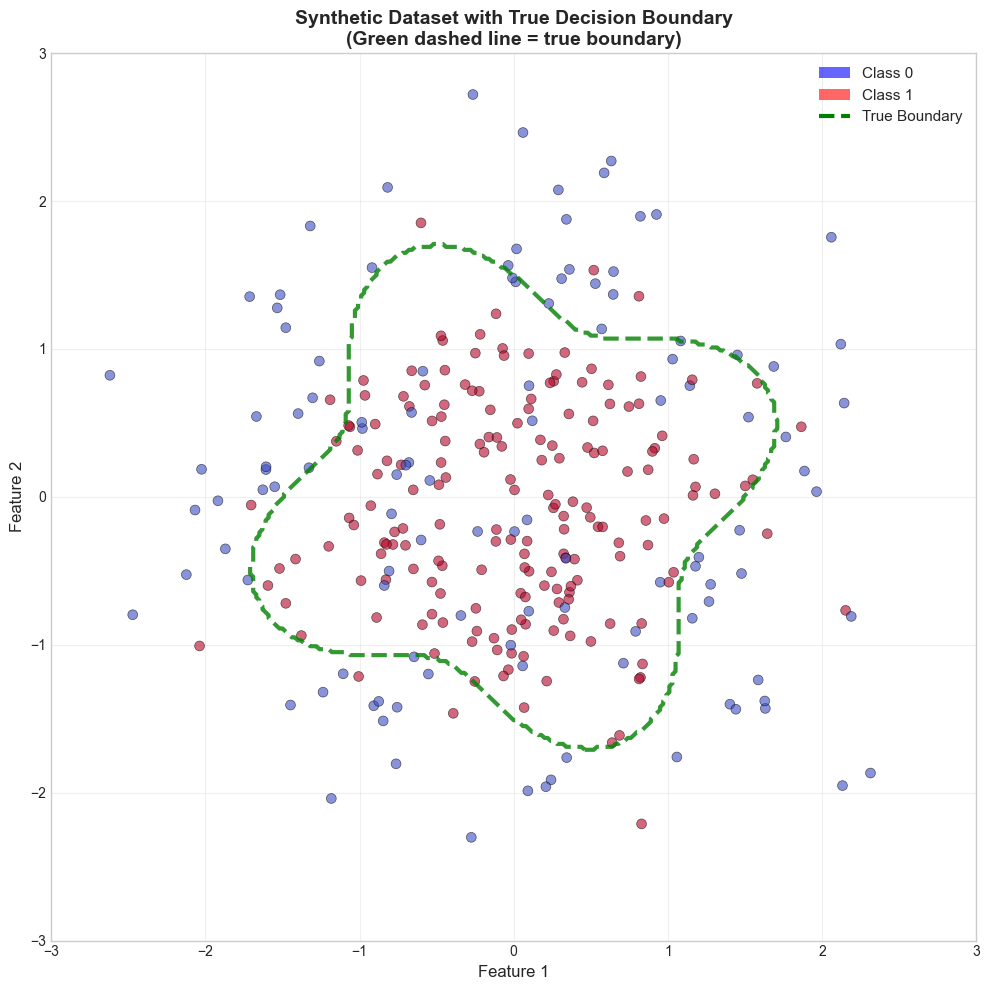

In [3]:
def plot_true_boundary(ax, resolution=0.02):
    """Plot the true decision boundary"""
    # Create a mesh
    x_min, x_max = -3, 3
    y_min, y_max = -3, 3
    xx, yy = np.meshgrid(np.arange(x_min, x_max, resolution),
                         np.arange(y_min, y_max, resolution))
    
    # Calculate true boundary for each point
    distances = np.sqrt(xx**2 + yy**2)
    angles = np.arctan2(yy, xx)
    true_boundary_radius = 1.5 + 0.3 * np.sin(4 * angles)
    
    # Points inside boundary = class 1, outside = class 0
    Z_true = (distances < true_boundary_radius).astype(int)
    
    # Plot boundary
    ax.contour(xx, yy, Z_true, levels=[0.5], colors='green', 
               linewidths=3, linestyles='--', alpha=0.8)
    
    return xx, yy, Z_true

# Visualize the data and true boundary
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

# Plot data points
scatter = ax.scatter(X_example[:, 0], X_example[:, 1], 
                     c=y_example, cmap='coolwarm', 
                     s=50, alpha=0.6, edgecolors='black', linewidth=0.5)

# Plot true boundary
plot_true_boundary(ax)

ax.set_xlim(-3, 3)
ax.set_ylim(-3, 3)
ax.set_xlabel('Feature 1', fontsize=12)
ax.set_ylabel('Feature 2', fontsize=12)
ax.set_title('Synthetic Dataset with True Decision Boundary\n(Green dashed line = true boundary)', 
             fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)

# Legend
legend_elements = [
    Patch(facecolor='blue', alpha=0.6, label='Class 0'),
    Patch(facecolor='red', alpha=0.6, label='Class 1'),
    plt.Line2D([0], [0], color='green', linewidth=3, linestyle='--', label='True Boundary')
]
ax.legend(handles=legend_elements, fontsize=11, loc='upper right')

plt.tight_layout()
plt.show()

## Part 2: Generate Multiple Training Datasets

To understand variance, we need to see how models behave across **different training sets** from the same distribution.

We'll create 20 different training datasets by:
1. Sampling different subsets from the population
2. Each dataset has the same size but different samples

This simulates what happens in practice: if you collected data again, you'd get different samples.

Generated 20 different training datasets
Each dataset has 150 samples


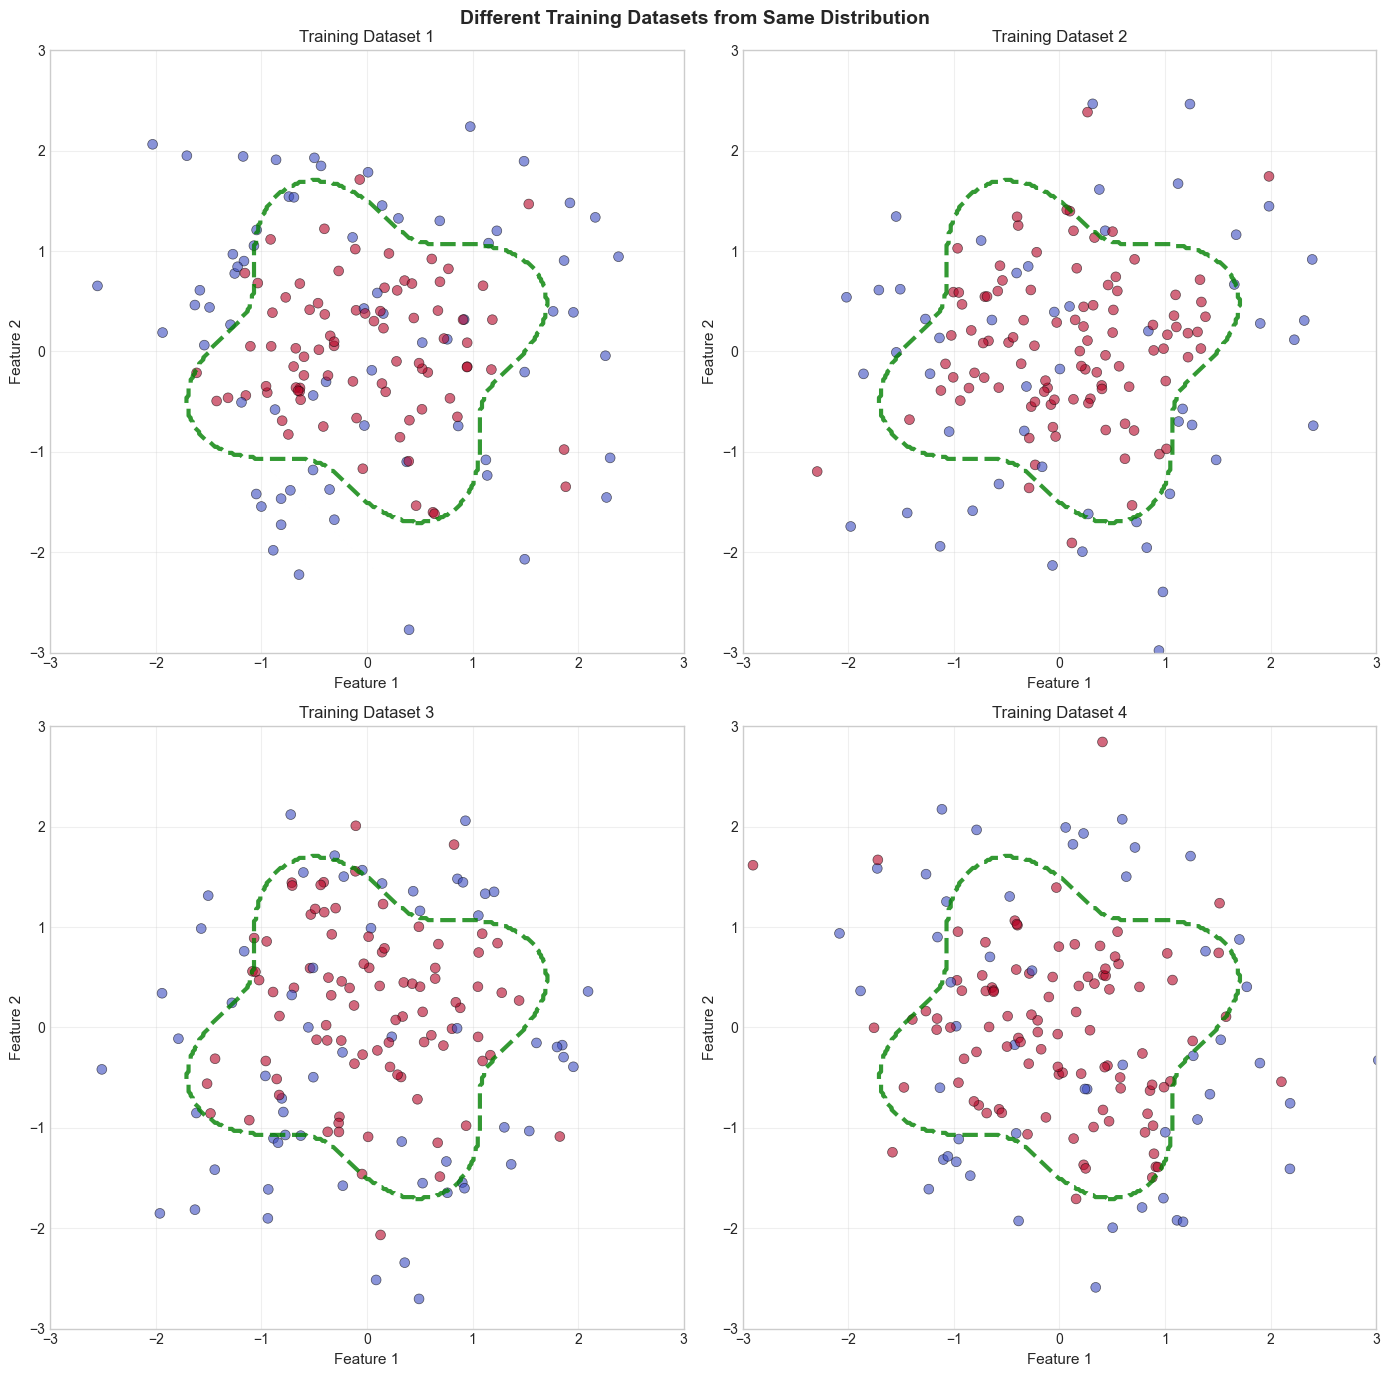


Observation: Each dataset samples different points, but all follow the same pattern


In [4]:
# Generate multiple training datasets
n_datasets = 20
n_train_samples = 150
datasets = []

for i in range(n_datasets):
    X_train, y_train, _ = generate_classification_data(
        n_samples=n_train_samples, 
        noise=0.15, 
        random_state=i * 10
    )
    datasets.append((X_train, y_train))

print(f"Generated {n_datasets} different training datasets")
print(f"Each dataset has {n_train_samples} samples")

# Visualize first 4 datasets
fig, axes = plt.subplots(2, 2, figsize=(14, 14))
axes = axes.flatten()

for idx in range(4):
    X_train, y_train = datasets[idx]
    
    axes[idx].scatter(X_train[:, 0], X_train[:, 1], 
                     c=y_train, cmap='coolwarm',
                     s=50, alpha=0.6, edgecolors='black', linewidth=0.5)
    
    plot_true_boundary(axes[idx])
    
    axes[idx].set_xlim(-3, 3)
    axes[idx].set_ylim(-3, 3)
    axes[idx].set_xlabel('Feature 1', fontsize=11)
    axes[idx].set_ylabel('Feature 2', fontsize=11)
    axes[idx].set_title(f'Training Dataset {idx + 1}', fontsize=12)
    axes[idx].grid(True, alpha=0.3)

plt.suptitle('Different Training Datasets from Same Distribution', 
             fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("\nObservation: Each dataset samples different points, but all follow the same pattern")

## Part 3: Train Models with Different Complexity

We'll train three types of models representing different bias-variance tradeoffs:

### 1. **High Bias, Low Variance** (Simple Model)
- **Model**: Logistic Regression (linear boundary)
- **Expected behavior**: Boundary stays similar across datasets (stable) but can't capture true pattern (biased)

### 2. **Balanced** (Moderate Complexity)
- **Model**: Random Forest with limited depth
- **Expected behavior**: Reasonable stability and reasonable accuracy

### 3. **Low Bias, High Variance** (Complex Model)
- **Model**: Deep Decision Tree (unlimited depth)
- **Expected behavior**: Boundary changes wildly across datasets (unstable) but can fit complex patterns

Let's see this in action!

In [5]:
def train_models_on_datasets(datasets):
    """Train three different models on all datasets"""
    
    models_config = {
        'Linear (High Bias)': LogisticRegression(max_iter=1000),
        'Random Forest (Balanced)': RandomForestClassifier(
            n_estimators=50, max_depth=5, random_state=42
        ),
        'Deep Tree (High Variance)': DecisionTreeClassifier(
            max_depth=None, min_samples_split=2
        )
    }
    
    trained_models = {name: [] for name in models_config.keys()}
    
    for X_train, y_train in datasets:
        for model_name, model_template in models_config.items():
            # Clone the model
            if model_name == 'Linear (High Bias)':
                model = LogisticRegression(max_iter=1000)
            elif model_name == 'Random Forest (Balanced)':
                model = RandomForestClassifier(
                    n_estimators=50, max_depth=5, random_state=42
                )
            else:
                model = DecisionTreeClassifier(
                    max_depth=None, min_samples_split=2
                )
            
            # Train
            model.fit(X_train, y_train)
            trained_models[model_name].append(model)
    
    return trained_models

# Train all models
print("Training models on all datasets...")
trained_models = train_models_on_datasets(datasets)
print(f"✓ Trained {len(trained_models)} model types on {n_datasets} datasets each")

Training models on all datasets...
✓ Trained 3 model types on 20 datasets each


## Part 4: Visualize Decision Boundary Stability

For each model type, we'll:
1. Plot all decision boundaries learned from different datasets (overlaid)
2. Calculate the **variance** in predictions at each point in space
3. Visualize regions where the boundary is **stable vs unstable**

**Key Visualization**:
- Each line = decision boundary from one dataset
- More spread between lines = higher variance
- Consistent lines = low variance (stable)

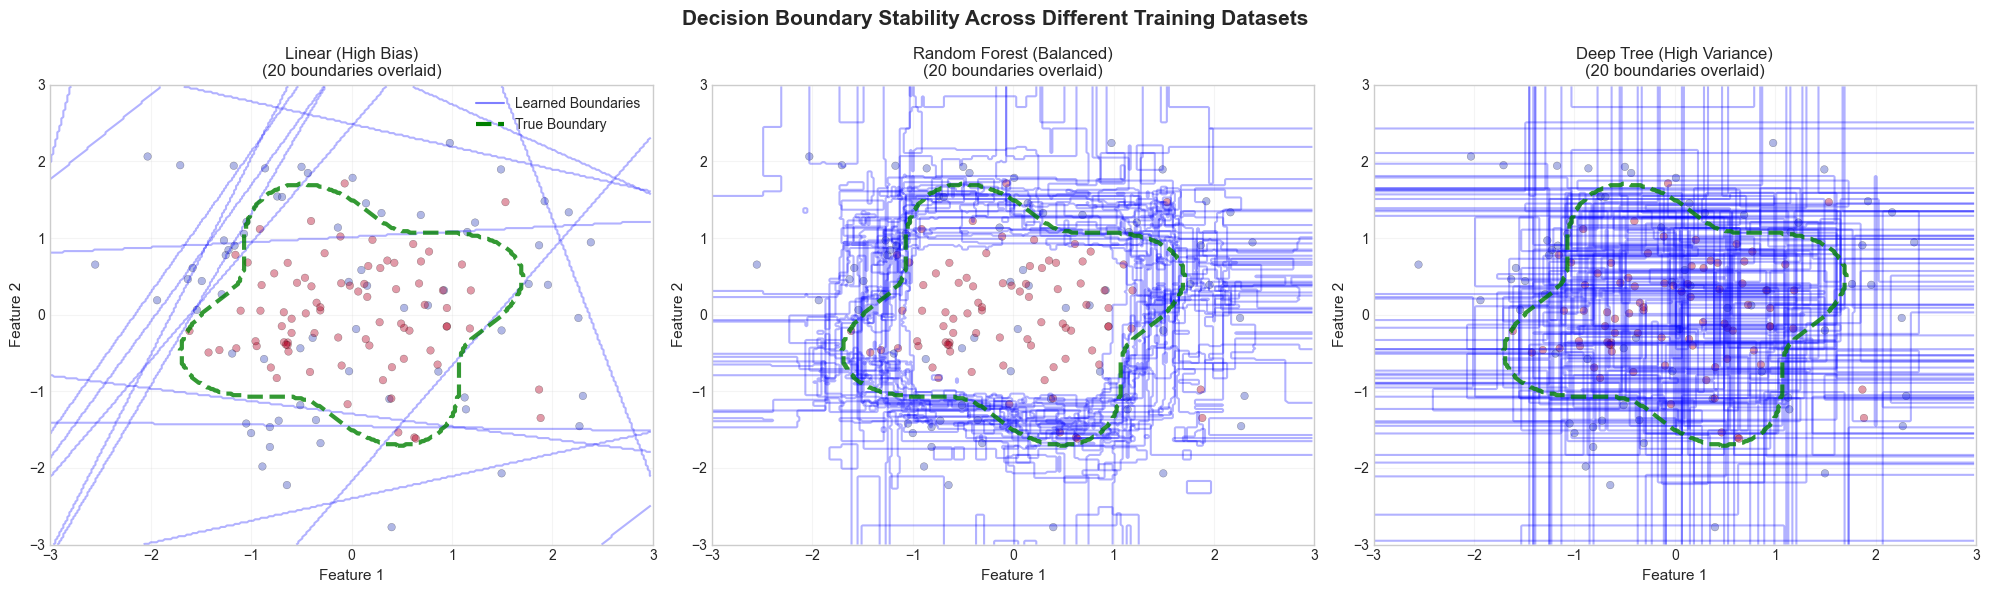


Observation:
- Linear model: Boundaries are very similar (low variance) but wrong (high bias)
- Deep Tree: Boundaries vary wildly (high variance) with different data
- Random Forest: Moderate stability with reasonable fit


In [6]:
def plot_decision_boundaries_overlay(models, datasets, model_name, ax, 
                                     resolution=0.02, show_data=True):
    """Plot decision boundaries from all trained models overlaid"""
    
    # Create mesh
    x_min, x_max = -3, 3
    y_min, y_max = -3, 3
    xx, yy = np.meshgrid(np.arange(x_min, x_max, resolution),
                         np.arange(y_min, y_max, resolution))
    mesh_points = np.c_[xx.ravel(), yy.ravel()]
    
    # Plot boundaries from each model
    for idx, model in enumerate(models):
        Z = model.predict(mesh_points).reshape(xx.shape)
        
        # Plot boundary (contour at decision boundary)
        ax.contour(xx, yy, Z, levels=[0.5], colors='blue', 
                   linewidths=1.5, alpha=0.3)
    
    # Plot true boundary
    plot_true_boundary(ax, resolution=resolution)
    
    # Optionally plot one dataset for reference
    if show_data:
        X_train, y_train = datasets[0]
        ax.scatter(X_train[:, 0], X_train[:, 1], 
                  c=y_train, cmap='coolwarm',
                  s=30, alpha=0.4, edgecolors='black', linewidth=0.3)
    
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.set_xlabel('Feature 1', fontsize=11)
    ax.set_ylabel('Feature 2', fontsize=11)
    ax.set_title(f'{model_name}\n({len(models)} boundaries overlaid)', fontsize=12)
    ax.grid(True, alpha=0.2)

# Create visualization
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

model_names = list(trained_models.keys())
for idx, model_name in enumerate(model_names):
    plot_decision_boundaries_overlay(
        trained_models[model_name], 
        datasets, 
        model_name, 
        axes[idx],
        show_data=True
    )

# Add legend
legend_elements = [
    plt.Line2D([0], [0], color='blue', linewidth=1.5, alpha=0.5, label='Learned Boundaries'),
    plt.Line2D([0], [0], color='green', linewidth=3, linestyle='--', label='True Boundary'),
]
axes[0].legend(handles=legend_elements, fontsize=10, loc='upper right')

plt.suptitle('Decision Boundary Stability Across Different Training Datasets', 
             fontsize=15, fontweight='bold')
plt.tight_layout()
plt.show()

print("\nObservation:")
print("- Linear model: Boundaries are very similar (low variance) but wrong (high bias)")
print("- Deep Tree: Boundaries vary wildly (high variance) with different data")
print("- Random Forest: Moderate stability with reasonable fit")

## Part 5: Quantify Decision Boundary Variance

Let's measure variance numerically:

For each point in the 2D space:
1. Get predictions from all 20 models
2. Calculate variance of predictions
3. High variance = boundary location is unstable at that point

**Variance Formula**:
For each point (x, y), we have predictions p₁, p₂, ..., p₂₀ from 20 models.

Variance = (1/20) Σ (pᵢ - p̄)²

Where p̄ is the average prediction across all models.

Linear (High Bias):
  Mean variance: 0.0116
  Max variance: 0.0435
  Std variance: 0.0078

Random Forest (Balanced):
  Mean variance: 0.0220
  Max variance: 0.0673
  Std variance: 0.0112

Deep Tree (High Variance):
  Mean variance: 0.1489
  Max variance: 0.2500
  Std variance: 0.0622



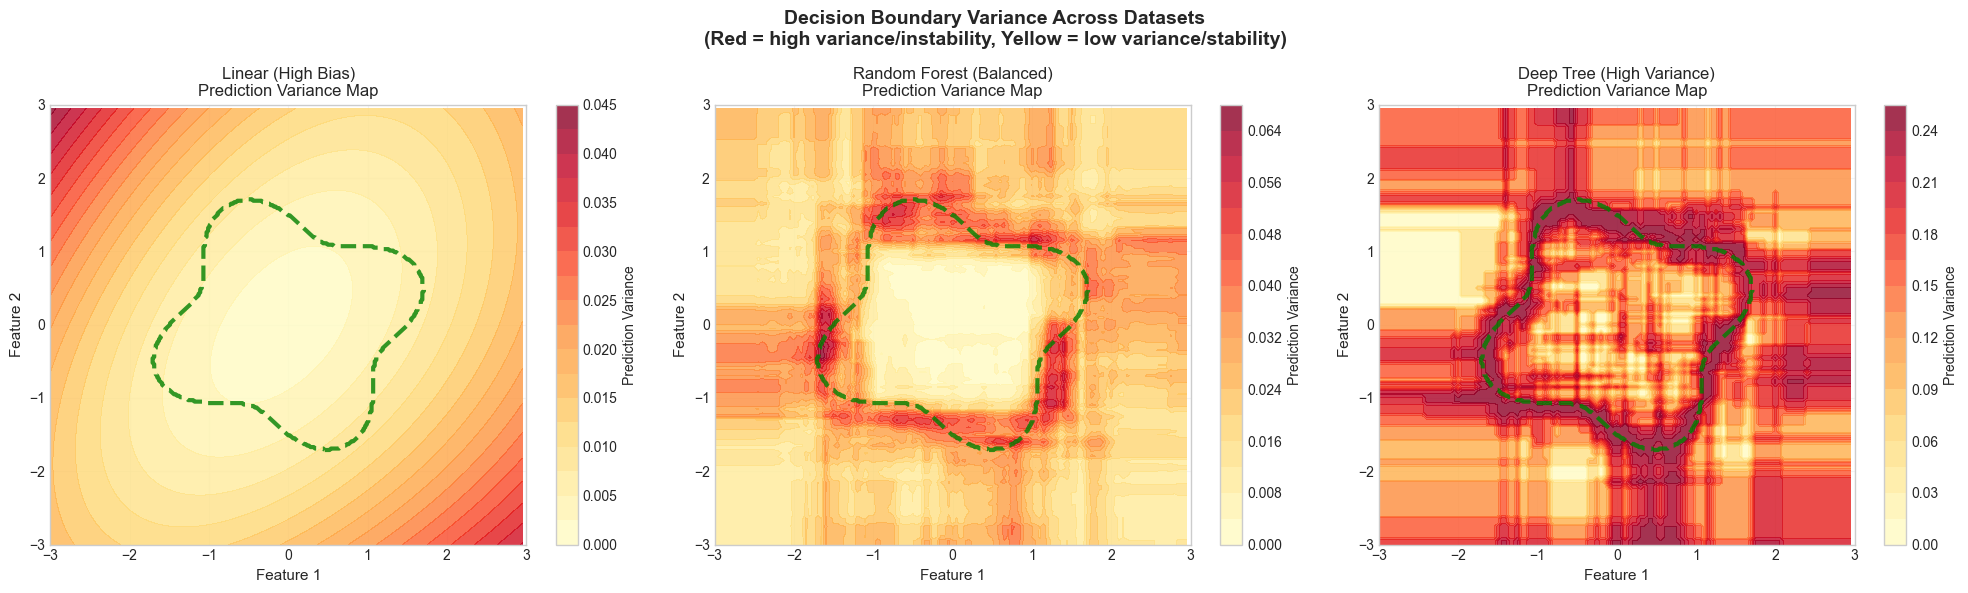

In [7]:
def calculate_prediction_variance(models, resolution=0.05):
    """Calculate variance in predictions across models"""
    
    # Create mesh
    x_min, x_max = -3, 3
    y_min, y_max = -3, 3
    xx, yy = np.meshgrid(np.arange(x_min, x_max, resolution),
                         np.arange(y_min, y_max, resolution))
    mesh_points = np.c_[xx.ravel(), yy.ravel()]
    
    # Collect predictions from all models
    all_predictions = []
    for model in models:
        if hasattr(model, 'predict_proba'):
            # Get probability of class 1
            pred = model.predict_proba(mesh_points)[:, 1]
        else:
            pred = model.predict(mesh_points)
        all_predictions.append(pred)
    
    # Stack predictions: shape (n_models, n_points)
    all_predictions = np.array(all_predictions)
    
    # Calculate variance across models for each point
    prediction_variance = np.var(all_predictions, axis=0)
    
    # Calculate mean prediction
    prediction_mean = np.mean(all_predictions, axis=0)
    
    return xx, yy, prediction_variance.reshape(xx.shape), prediction_mean.reshape(xx.shape)

# Calculate variance for each model type
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

for idx, model_name in enumerate(model_names):
    xx, yy, variance, mean_pred = calculate_prediction_variance(
        trained_models[model_name], resolution=0.05
    )
    
    # Plot variance as heatmap
    im = axes[idx].contourf(xx, yy, variance, levels=20, cmap='YlOrRd', alpha=0.8)
    
    # Overlay true boundary
    plot_true_boundary(axes[idx], resolution=0.02)
    
    # Add colorbar
    cbar = plt.colorbar(im, ax=axes[idx])
    cbar.set_label('Prediction Variance', fontsize=10)
    
    axes[idx].set_xlim(-3, 3)
    axes[idx].set_ylim(-3, 3)
    axes[idx].set_xlabel('Feature 1', fontsize=11)
    axes[idx].set_ylabel('Feature 2', fontsize=11)
    axes[idx].set_title(f'{model_name}\nPrediction Variance Map', fontsize=12)
    axes[idx].grid(True, alpha=0.2)
    
    # Print statistics
    print(f"{model_name}:")
    print(f"  Mean variance: {np.mean(variance):.4f}")
    print(f"  Max variance: {np.max(variance):.4f}")
    print(f"  Std variance: {np.std(variance):.4f}\n")

plt.suptitle('Decision Boundary Variance Across Datasets\n(Red = high variance/instability, Yellow = low variance/stability)', 
             fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

## Part 6: Quantify Bias

**Bias** = How far is the **average** learned boundary from the **true** boundary?

For each model type:
1. Average predictions from all 20 models at each point
2. Compare to true labels
3. Calculate the difference

**Bias Formula**:
Bias² = (E[f̂(x)] - f_true(x))²

Where:
- E[f̂(x)] = average prediction across all trained models
- f_true(x) = true label

Linear (High Bias):
  Mean squared bias: 0.3344
  Max squared bias: 0.4046

Random Forest (Balanced):
  Mean squared bias: 0.0725
  Max squared bias: 0.5002

Deep Tree (High Variance):
  Mean squared bias: 0.0550
  Max squared bias: 0.5625



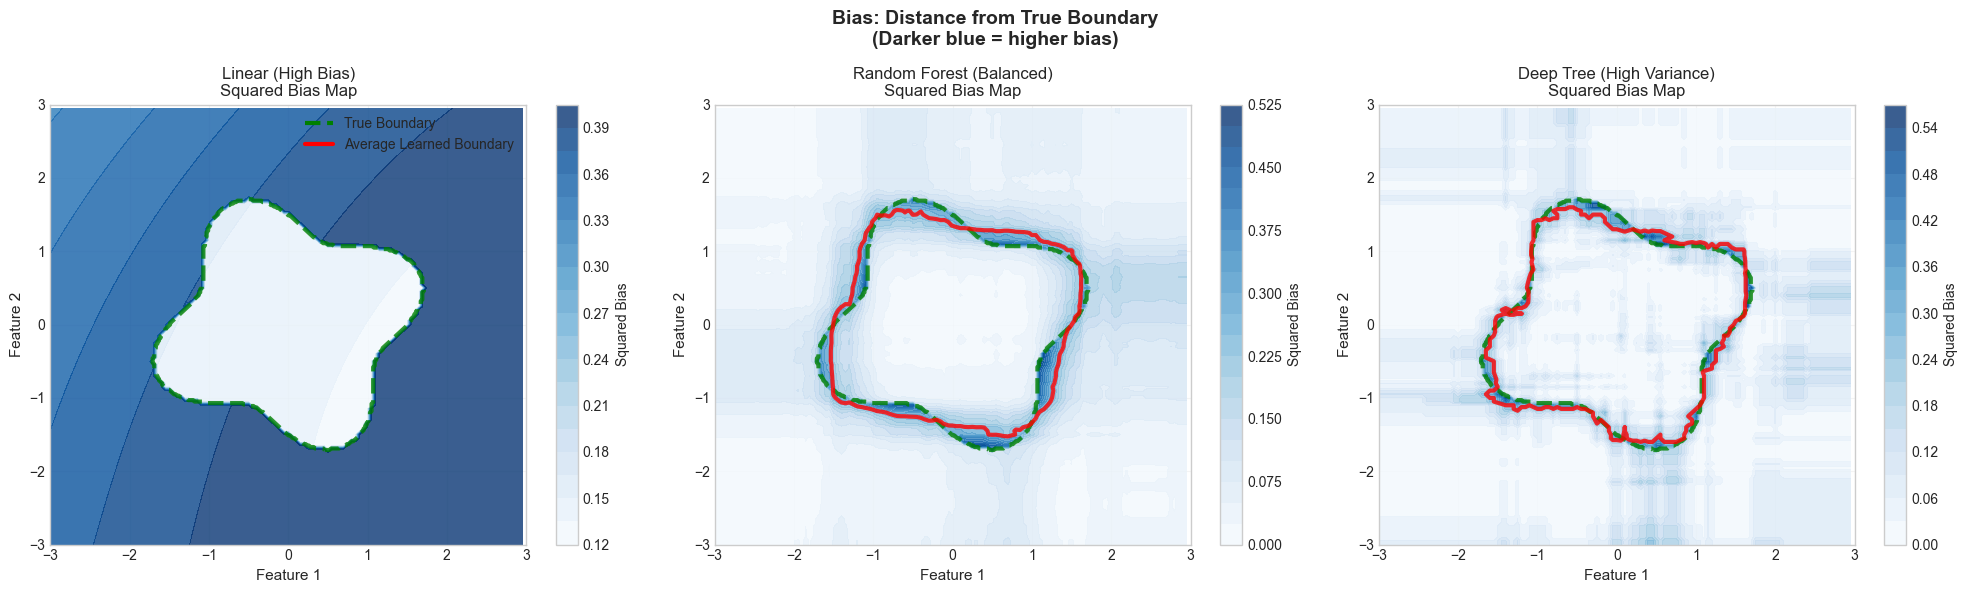

In [8]:
def calculate_bias(models, resolution=0.05):
    """Calculate squared bias compared to true boundary"""
    
    # Create mesh
    x_min, x_max = -3, 3
    y_min, y_max = -3, 3
    xx, yy = np.meshgrid(np.arange(x_min, x_max, resolution),
                         np.arange(y_min, y_max, resolution))
    mesh_points = np.c_[xx.ravel(), yy.ravel()]
    
    # True labels
    distances = np.sqrt(mesh_points[:, 0]**2 + mesh_points[:, 1]**2)
    angles = np.arctan2(mesh_points[:, 1], mesh_points[:, 0])
    true_boundary_radius = 1.5 + 0.3 * np.sin(4 * angles)
    y_true = (distances < true_boundary_radius).astype(float)
    
    # Collect predictions from all models
    all_predictions = []
    for model in models:
        if hasattr(model, 'predict_proba'):
            pred = model.predict_proba(mesh_points)[:, 1]
        else:
            pred = model.predict(mesh_points).astype(float)
        all_predictions.append(pred)
    
    # Average prediction across models
    mean_prediction = np.mean(all_predictions, axis=0)
    
    # Squared bias
    squared_bias = (mean_prediction - y_true) ** 2
    
    return xx, yy, squared_bias.reshape(xx.shape), mean_prediction.reshape(xx.shape)

# Calculate bias for each model type
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

for idx, model_name in enumerate(model_names):
    xx, yy, squared_bias, mean_pred = calculate_bias(
        trained_models[model_name], resolution=0.05
    )
    
    # Plot squared bias as heatmap
    im = axes[idx].contourf(xx, yy, squared_bias, levels=20, cmap='Blues', alpha=0.8)
    
    # Overlay true boundary
    plot_true_boundary(axes[idx], resolution=0.02)
    
    # Overlay average learned boundary
    axes[idx].contour(xx, yy, mean_pred, levels=[0.5], colors='red', 
                      linewidths=3, linestyles='-', alpha=0.8)
    
    # Add colorbar
    cbar = plt.colorbar(im, ax=axes[idx])
    cbar.set_label('Squared Bias', fontsize=10)
    
    axes[idx].set_xlim(-3, 3)
    axes[idx].set_ylim(-3, 3)
    axes[idx].set_xlabel('Feature 1', fontsize=11)
    axes[idx].set_ylabel('Feature 2', fontsize=11)
    axes[idx].set_title(f'{model_name}\nSquared Bias Map', fontsize=12)
    axes[idx].grid(True, alpha=0.2)
    
    # Print statistics
    print(f"{model_name}:")
    print(f"  Mean squared bias: {np.mean(squared_bias):.4f}")
    print(f"  Max squared bias: {np.max(squared_bias):.4f}\n")

# Add legend
legend_elements = [
    plt.Line2D([0], [0], color='green', linewidth=3, linestyle='--', label='True Boundary'),
    plt.Line2D([0], [0], color='red', linewidth=3, linestyle='-', label='Average Learned Boundary'),
]
axes[0].legend(handles=legend_elements, fontsize=10, loc='upper right')

plt.suptitle('Bias: Distance from True Boundary\n(Darker blue = higher bias)', 
             fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

## Part 7: Complete Bias-Variance Decomposition

The expected prediction error can be decomposed as:

**Expected Error = Bias² + Variance + Irreducible Error**

Let's visualize all three components for each model type:

1. **Bias²**: How far average prediction is from truth
2. **Variance**: How much predictions fluctuate across datasets  
3. **Total Error**: Bias² + Variance (ignoring irreducible error)

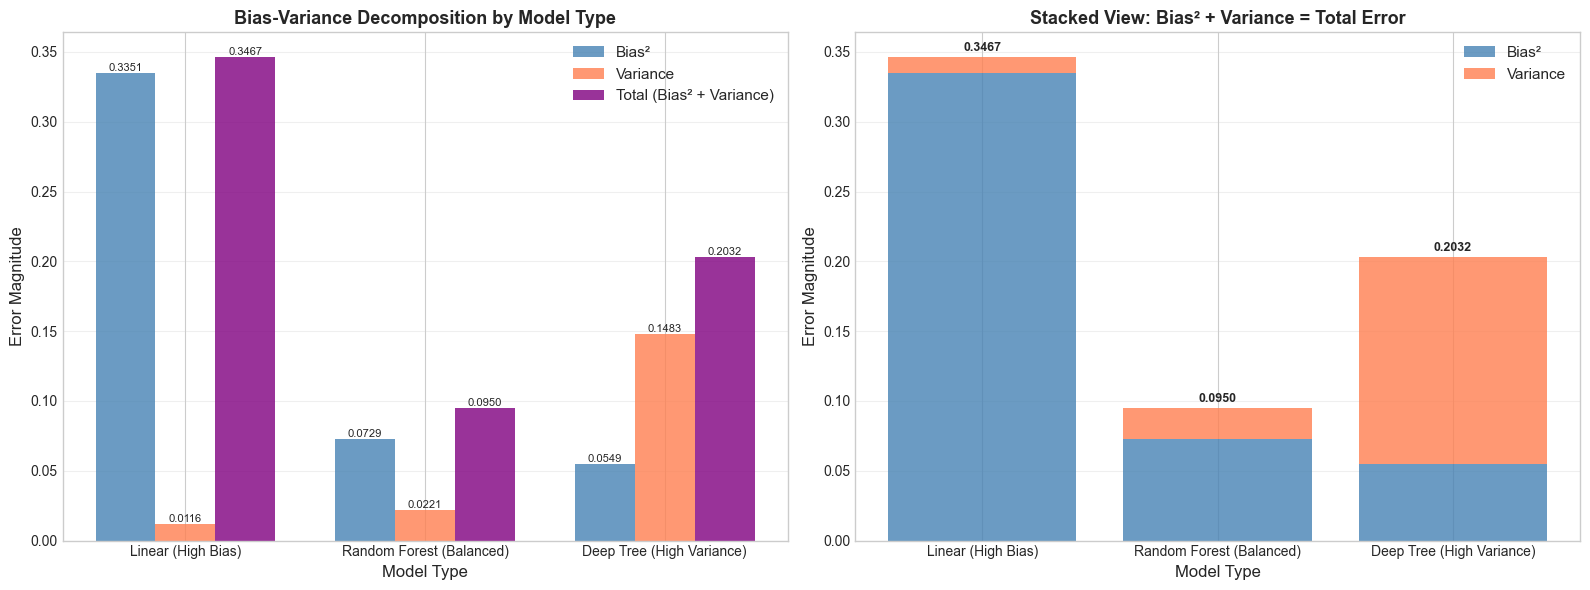


BIAS-VARIANCE DECOMPOSITION RESULTS

Linear (High Bias):
  Bias²:       0.335073
  Variance:    0.011601
  Total Error: 0.346675
  Ratio (Var/Bias²): 0.03

Random Forest (Balanced):
  Bias²:       0.072918
  Variance:    0.022057
  Total Error: 0.094974
  Ratio (Var/Bias²): 0.30

Deep Tree (High Variance):
  Bias²:       0.054944
  Variance:    0.148282
  Total Error: 0.203227
  Ratio (Var/Bias²): 2.70


In [9]:
def compute_bias_variance_stats(models, resolution=0.08):
    """Compute average bias and variance statistics"""
    
    # Create mesh
    x_min, x_max = -3, 3
    y_min, y_max = -3, 3
    xx, yy = np.meshgrid(np.arange(x_min, x_max, resolution),
                         np.arange(y_min, y_max, resolution))
    mesh_points = np.c_[xx.ravel(), yy.ravel()]
    
    # True labels
    distances = np.sqrt(mesh_points[:, 0]**2 + mesh_points[:, 1]**2)
    angles = np.arctan2(mesh_points[:, 1], mesh_points[:, 0])
    true_boundary_radius = 1.5 + 0.3 * np.sin(4 * angles)
    y_true = (distances < true_boundary_radius).astype(float)
    
    # Collect predictions
    all_predictions = []
    for model in models:
        if hasattr(model, 'predict_proba'):
            pred = model.predict_proba(mesh_points)[:, 1]
        else:
            pred = model.predict(mesh_points).astype(float)
        all_predictions.append(pred)
    
    all_predictions = np.array(all_predictions)
    
    # Calculate metrics
    mean_prediction = np.mean(all_predictions, axis=0)
    variance = np.var(all_predictions, axis=0)
    squared_bias = (mean_prediction - y_true) ** 2
    
    # Average over all points
    avg_bias_sq = np.mean(squared_bias)
    avg_variance = np.mean(variance)
    total_error = avg_bias_sq + avg_variance
    
    return avg_bias_sq, avg_variance, total_error

# Compute for all model types
results = {}
for model_name in model_names:
    bias_sq, variance, total = compute_bias_variance_stats(
        trained_models[model_name]
    )
    results[model_name] = {
        'bias_squared': bias_sq,
        'variance': variance,
        'total_error': total
    }

# Create summary visualization
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Bar chart
model_labels = list(results.keys())
bias_values = [results[m]['bias_squared'] for m in model_labels]
variance_values = [results[m]['variance'] for m in model_labels]
total_values = [results[m]['total_error'] for m in model_labels]

x_pos = np.arange(len(model_labels))
width = 0.25

bars1 = axes[0].bar(x_pos - width, bias_values, width, 
                    label='Bias²', color='steelblue', alpha=0.8)
bars2 = axes[0].bar(x_pos, variance_values, width, 
                    label='Variance', color='coral', alpha=0.8)
bars3 = axes[0].bar(x_pos + width, total_values, width, 
                    label='Total (Bias² + Variance)', color='purple', alpha=0.8)

axes[0].set_xlabel('Model Type', fontsize=12)
axes[0].set_ylabel('Error Magnitude', fontsize=12)
axes[0].set_title('Bias-Variance Decomposition by Model Type', fontsize=13, fontweight='bold')
axes[0].set_xticks(x_pos)
axes[0].set_xticklabels(model_labels, fontsize=10)
axes[0].legend(fontsize=11)
axes[0].grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for bars in [bars1, bars2, bars3]:
    for bar in bars:
        height = bar.get_height()
        axes[0].text(bar.get_x() + bar.get_width()/2., height,
                    f'{height:.4f}',
                    ha='center', va='bottom', fontsize=8)

# Stacked bar chart
bias_sq_vals = [results[m]['bias_squared'] for m in model_labels]
var_vals = [results[m]['variance'] for m in model_labels]

axes[1].bar(model_labels, bias_sq_vals, label='Bias²', 
            color='steelblue', alpha=0.8)
axes[1].bar(model_labels, var_vals, bottom=bias_sq_vals, 
            label='Variance', color='coral', alpha=0.8)

axes[1].set_xlabel('Model Type', fontsize=12)
axes[1].set_ylabel('Error Magnitude', fontsize=12)
axes[1].set_title('Stacked View: Bias² + Variance = Total Error', fontsize=13, fontweight='bold')
axes[1].legend(fontsize=11)
axes[1].grid(True, alpha=0.3, axis='y')
axes[1].tick_params(axis='x', labelsize=10)

# Add total labels
for i, model in enumerate(model_labels):
    total = results[model]['total_error']
    axes[1].text(i, total + 0.002, f'{total:.4f}',
                ha='center', va='bottom', fontsize=9, fontweight='bold')

plt.tight_layout()
plt.show()

# Print detailed results
print("\n" + "="*70)
print("BIAS-VARIANCE DECOMPOSITION RESULTS")
print("="*70)
for model_name in model_labels:
    print(f"\n{model_name}:")
    print(f"  Bias²:       {results[model_name]['bias_squared']:.6f}")
    print(f"  Variance:    {results[model_name]['variance']:.6f}")
    print(f"  Total Error: {results[model_name]['total_error']:.6f}")
    print(f"  Ratio (Var/Bias²): {results[model_name]['variance']/results[model_name]['bias_squared']:.2f}")
print("="*70)

## Part 8: Quantifying Boundary Stability

Let's create a specific metric for **decision boundary stability**:

For each pair of models trained on different datasets:
1. Calculate the **average distance** between their decision boundaries
2. Lower distance = more stable boundaries

We'll measure this by sampling points along each boundary and computing distances.

DECISION BOUNDARY STABILITY ANALYSIS
(Disagreement rate = % of points where two models predict differently)

Linear (High Bias):
  Average disagreement rate: 0.2159 (21.59%)
  Std of disagreement: 0.1385
  Interpretation: MODERATE

Random Forest (Balanced):
  Average disagreement rate: 0.1572 (15.72%)
  Std of disagreement: 0.0384
  Interpretation: MODERATE

Deep Tree (High Variance):
  Average disagreement rate: 0.3142 (31.42%)
  Std of disagreement: 0.0769
  Interpretation: UNSTABLE



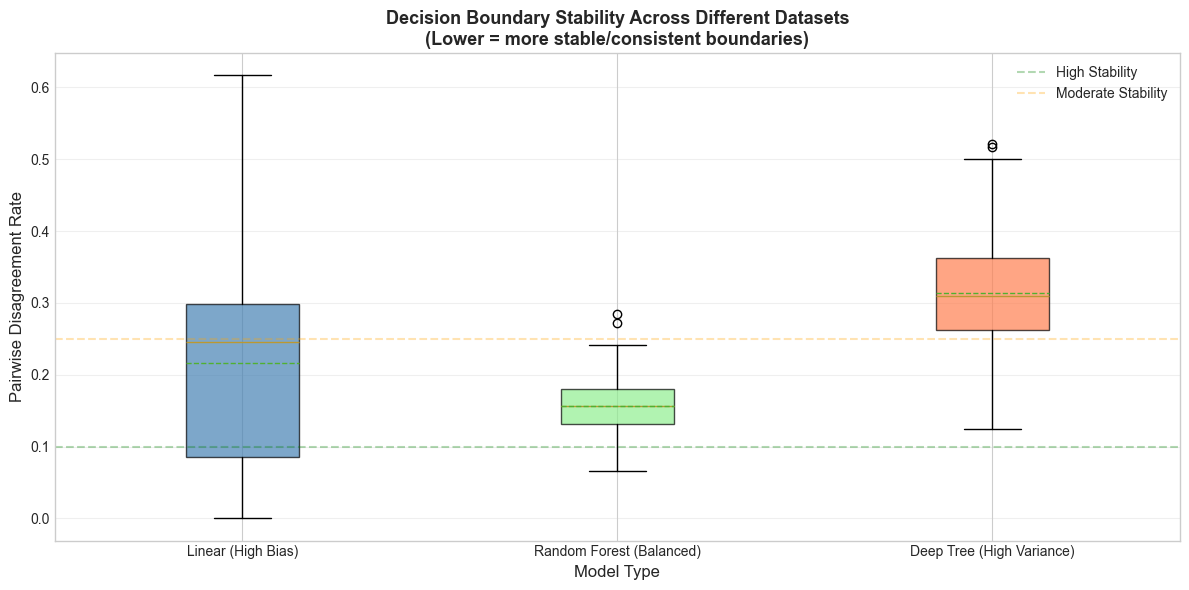

In [10]:
def calculate_boundary_stability(models, n_samples=1000):
    """
    Measure how much decision boundaries vary across models.
    Returns average disagreement rate between model pairs.
    """
    
    # Sample random points in the space
    np.random.seed(42)
    X_sample = np.random.uniform(-3, 3, (n_samples, 2))
    
    # Get predictions from all models
    predictions = []
    for model in models:
        pred = model.predict(X_sample)
        predictions.append(pred)
    
    predictions = np.array(predictions)  # shape: (n_models, n_samples)
    
    # Calculate pairwise disagreement
    n_models = len(models)
    disagreements = []
    
    for i in range(n_models):
        for j in range(i + 1, n_models):
            disagreement_rate = np.mean(predictions[i] != predictions[j])
            disagreements.append(disagreement_rate)
    
    avg_disagreement = np.mean(disagreements)
    std_disagreement = np.std(disagreements)
    
    return avg_disagreement, std_disagreement, disagreements

# Calculate stability for each model type
print("DECISION BOUNDARY STABILITY ANALYSIS")
print("="*70)
print("(Disagreement rate = % of points where two models predict differently)")
print("="*70 + "\n")

stability_results = {}
for model_name in model_names:
    avg_dis, std_dis, all_dis = calculate_boundary_stability(
        trained_models[model_name]
    )
    stability_results[model_name] = {
        'mean': avg_dis,
        'std': std_dis,
        'all': all_dis
    }
    
    print(f"{model_name}:")
    print(f"  Average disagreement rate: {avg_dis:.4f} ({avg_dis*100:.2f}%)")
    print(f"  Std of disagreement: {std_dis:.4f}")
    print(f"  Interpretation: {'STABLE' if avg_dis < 0.1 else 'MODERATE' if avg_dis < 0.25 else 'UNSTABLE'}")
    print()

# Visualize as box plot
fig, ax = plt.subplots(1, 1, figsize=(12, 6))

data_to_plot = [stability_results[m]['all'] for m in model_names]
bp = ax.boxplot(data_to_plot, labels=model_names, patch_artist=True,
                showmeans=True, meanline=True)

# Color boxes
colors = ['steelblue', 'lightgreen', 'coral']
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)

ax.set_ylabel('Pairwise Disagreement Rate', fontsize=12)
ax.set_xlabel('Model Type', fontsize=12)
ax.set_title('Decision Boundary Stability Across Different Datasets\n(Lower = more stable/consistent boundaries)', 
             fontsize=13, fontweight='bold')
ax.grid(True, alpha=0.3, axis='y')
ax.tick_params(axis='x', labelsize=10)

# Add horizontal reference lines
ax.axhline(0.1, color='green', linestyle='--', alpha=0.3, label='High Stability')
ax.axhline(0.25, color='orange', linestyle='--', alpha=0.3, label='Moderate Stability')
ax.legend(fontsize=10)

plt.tight_layout()
plt.show()

## Part 9: Side-by-Side Comparison

Let's create a comprehensive comparison showing:
1. Individual boundaries from different datasets
2. Variance heatmap
3. Average boundary vs true boundary

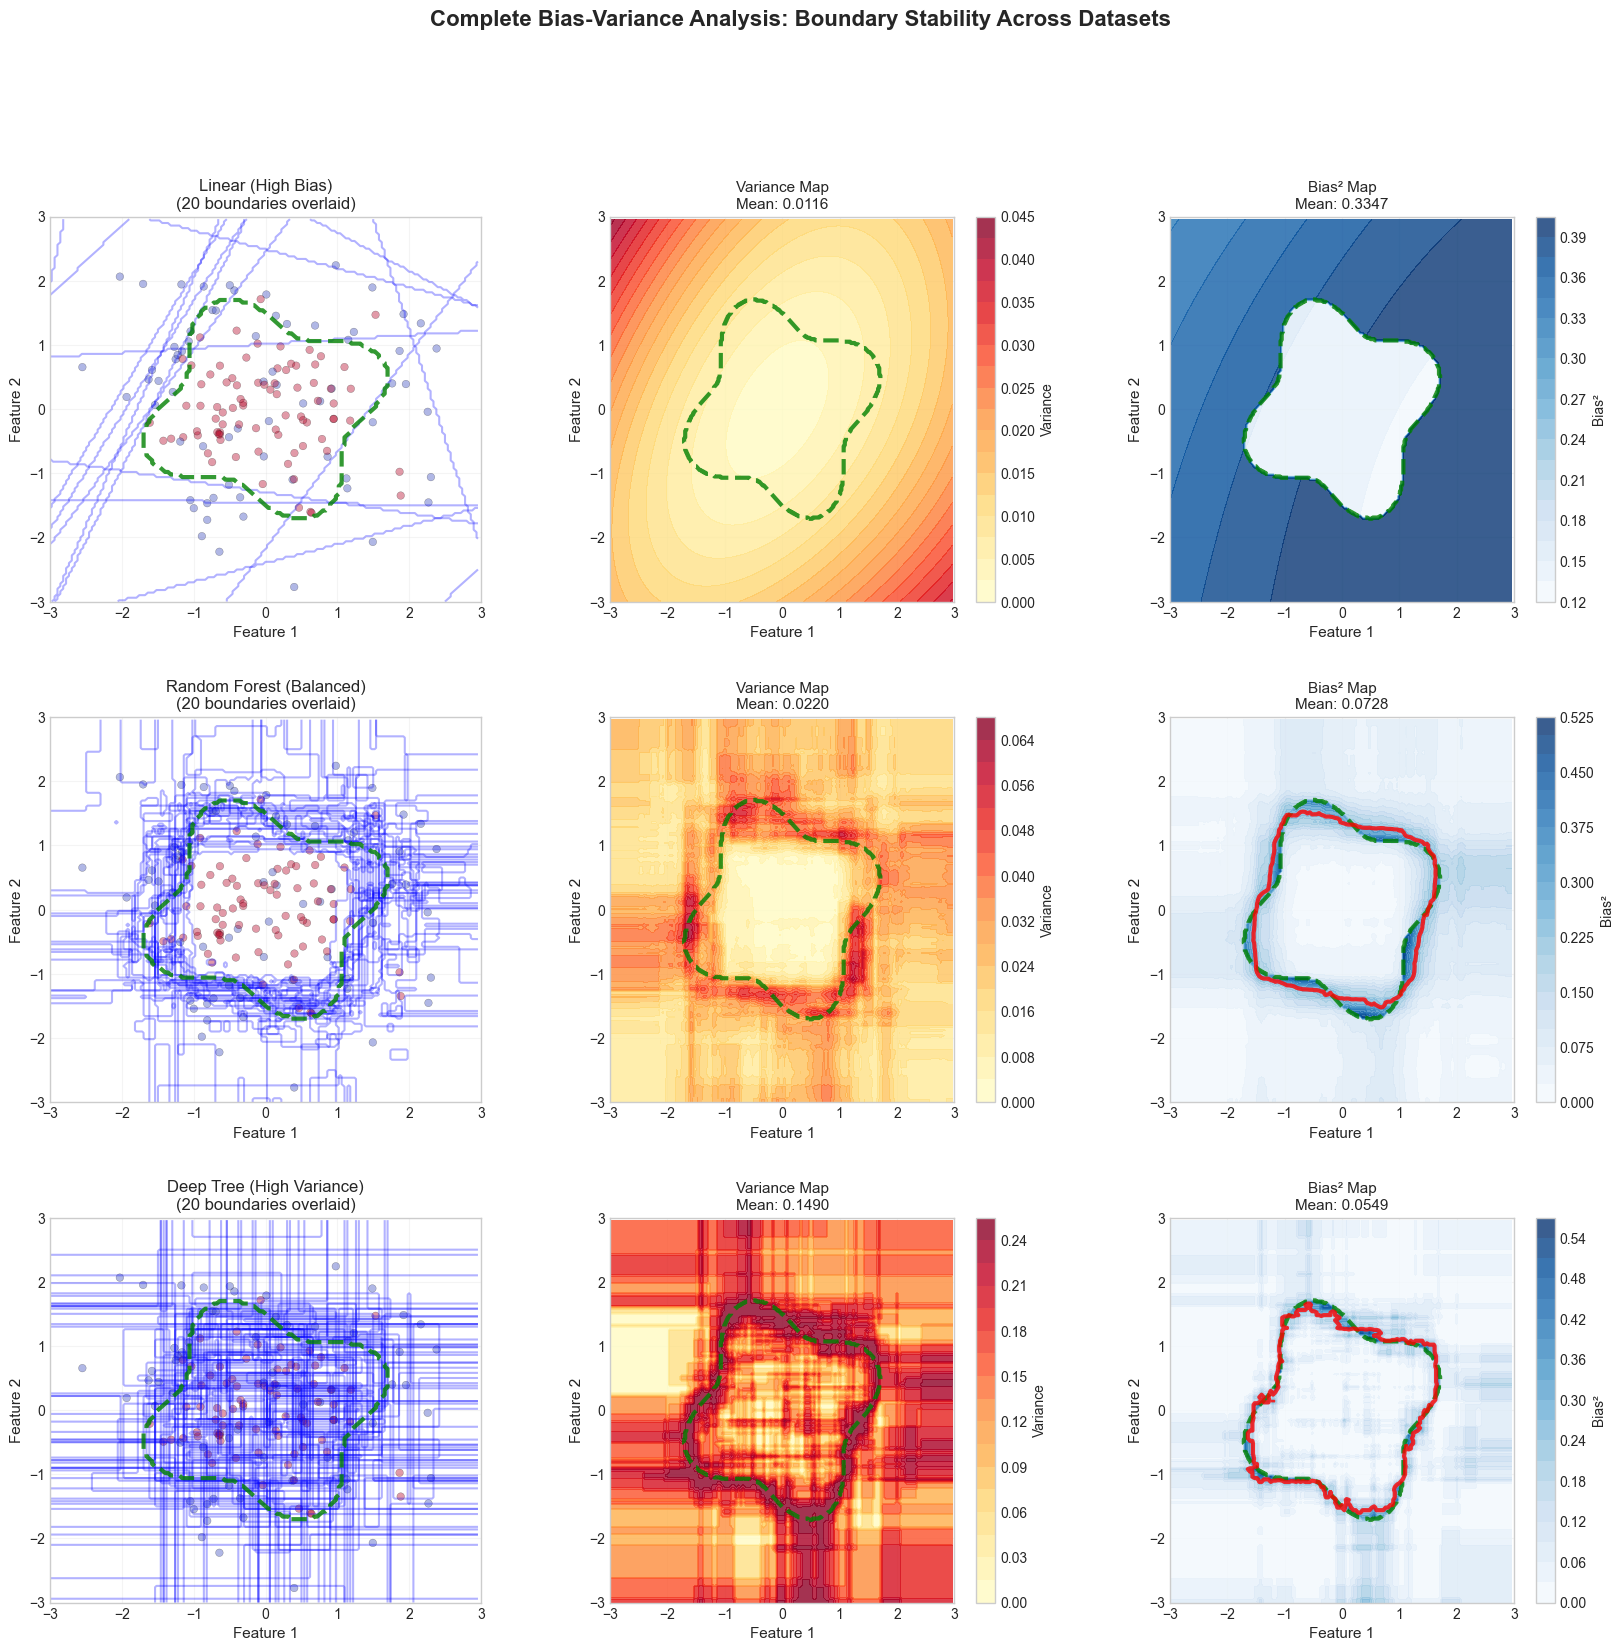

In [11]:
# Create a comprehensive 3x3 grid
fig = plt.figure(figsize=(20, 18))
gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)

resolution = 0.04

for row, model_name in enumerate(model_names):
    models = trained_models[model_name]
    
    # Column 0: Overlay of all boundaries
    ax0 = fig.add_subplot(gs[row, 0])
    plot_decision_boundaries_overlay(models, datasets, model_name, ax0, 
                                     resolution=resolution, show_data=True)
    
    # Column 1: Variance heatmap
    ax1 = fig.add_subplot(gs[row, 1])
    xx, yy, variance, mean_pred = calculate_prediction_variance(models, resolution=resolution)
    im1 = ax1.contourf(xx, yy, variance, levels=20, cmap='YlOrRd', alpha=0.8)
    plot_true_boundary(ax1, resolution=0.02)
    ax1.set_xlim(-3, 3)
    ax1.set_ylim(-3, 3)
    ax1.set_xlabel('Feature 1', fontsize=11)
    ax1.set_ylabel('Feature 2', fontsize=11)
    ax1.set_title(f'Variance Map\nMean: {np.mean(variance):.4f}', fontsize=11)
    ax1.grid(True, alpha=0.2)
    plt.colorbar(im1, ax=ax1, label='Variance')
    
    # Column 2: Bias heatmap
    ax2 = fig.add_subplot(gs[row, 2])
    xx, yy, squared_bias, mean_pred = calculate_bias(models, resolution=resolution)
    im2 = ax2.contourf(xx, yy, squared_bias, levels=20, cmap='Blues', alpha=0.8)
    plot_true_boundary(ax2, resolution=0.02)
    ax2.contour(xx, yy, mean_pred, levels=[0.5], colors='red', 
                linewidths=3, alpha=0.8)
    ax2.set_xlim(-3, 3)
    ax2.set_ylim(-3, 3)
    ax2.set_xlabel('Feature 1', fontsize=11)
    ax2.set_ylabel('Feature 2', fontsize=11)
    ax2.set_title(f'Bias² Map\nMean: {np.mean(squared_bias):.4f}', fontsize=11)
    ax2.grid(True, alpha=0.2)
    plt.colorbar(im2, ax=ax2, label='Bias²')

# Add overall title
plt.suptitle('Complete Bias-Variance Analysis: Boundary Stability Across Datasets', 
             fontsize=16, fontweight='bold', y=0.995)

plt.show()

## Summary: Bias and Variance Through Decision Boundary Stability

### What We've Demonstrated:

### 1. **High Bias, Low Variance (Linear Model)**
   - ✅ **Stable**: Boundaries barely change across different datasets
   - ❌ **Biased**: Cannot capture the true curved boundary
   - **Geometric**: The hypothesis space (linear boundaries) doesn't contain the true boundary
   - **Result**: Consistently wrong predictions, but at least consistent!

### 2. **Low Bias, High Variance (Deep Tree)**
   - ✅ **Flexible**: Can approximate the true boundary closely
   - ❌ **Unstable**: Wild variations in boundaries across datasets
   - **Geometric**: Different training sets lead to drastically different decision boundaries
   - **Result**: Sometimes very accurate, sometimes very wrong - unpredictable!

### 3. **Balanced (Random Forest)**
   - ✅ **Moderately Stable**: Boundaries are reasonably consistent
   - ✅ **Reasonably Accurate**: Captures the general pattern
   - **Geometric**: Small perturbations in data cause small changes in boundary
   - **Result**: Best overall performance through bias-variance tradeoff

---

## Key Insights:

### Variance as Boundary Instability:
- **High variance** means: "If I collect new training data, my decision boundary will be completely different"
- Geometrically: The learned function f̂ is extremely sensitive to which specific samples you observe
- Visually: The cloud of boundaries spreads widely across space

### Bias as Systematic Error:
- **High bias** means: "Even averaging over all possible training sets, my boundary is still wrong"
- Geometrically: The average learned boundary E[f̂] is far from the true boundary f*
- Visually: The center of the boundary cloud is offset from the true boundary

---

## Mathematical Connection:
```
At each point x in feature space:

Expected Error(x) = Bias²(x) + Variance(x) + Noise

Where:
- Bias²(x) = (E[f̂(x)] - f*(x))²     [Average boundary vs truth]
- Variance(x) = E[(f̂(x) - E[f̂(x)])²]  [Spread of boundaries]
```

---

## Practical Implications:

1. **Model Selection**: Choose complexity based on:
   - How much data you have (more data → can handle more complexity)
   - How stable you need predictions to be (production systems → favor stability)
   - Whether you can ensemble (averaging reduces variance)

2. **Diagnosing Issues**:
   - Stable but wrong boundaries → **increase model complexity**
   - Unstable boundaries → **reduce complexity or add regularization**
   - Both unstable AND wrong → **need more/better data**

3. **Boundary Stability as a Metric**:
   - Train multiple models on bootstrap samples
   - Measure disagreement rate
   - High disagreement = warning sign for high variance

---

## Conclusion:

**Bias and variance are not just abstract statistical concepts** - they have clear geometric interpretations:

- **Variance** = How much your decision boundary **wobbles** with different data
- **Bias** = How far your **average** boundary is from the **truth**

The art of machine learning is finding models whose boundaries are both **stable** (low variance) and **accurate** (low bias).


                    FINAL SUMMARY: BIAS-VARIANCE-STABILITY
Model Type                     Bias²        Variance     Total        Stability   
--------------------------------------------------------------------------------
Linear (High Bias)             0.335073     0.011601     0.346675     0.2159      
  └─ High Bias
Random Forest (Balanced)       0.072918     0.022057     0.094974     0.1572      
  └─ Balanced
Deep Tree (High Variance)      0.054944     0.148282     0.203227     0.3142      
  └─ High Variance

Stability = Average disagreement rate between model pairs (lower is better)
Bias² = Squared distance from true boundary (lower is better)
Variance = Instability in predictions across datasets (lower is better)


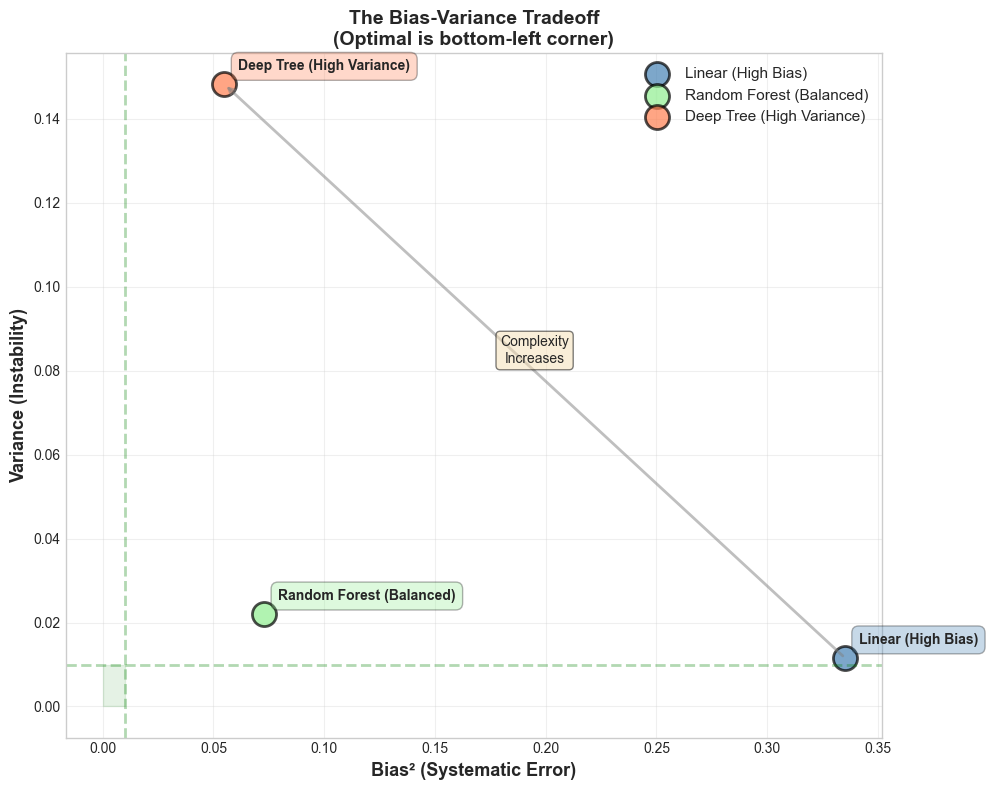


✓ Analysis complete!


In [12]:
# Create final summary table
print("\n" + "="*80)
print(" "*20 + "FINAL SUMMARY: BIAS-VARIANCE-STABILITY")
print("="*80)
print(f"{'Model Type':<30} {'Bias²':<12} {'Variance':<12} {'Total':<12} {'Stability':<12}")
print("-"*80)

for model_name in model_names:
    bias_sq = results[model_name]['bias_squared']
    variance = results[model_name]['variance']
    total = results[model_name]['total_error']
    stability = stability_results[model_name]['mean']
    
    # Determine category
    if "Linear" in model_name:
        category = "High Bias"
    elif "Tree" in model_name:
        category = "High Variance"
    else:
        category = "Balanced"
    
    print(f"{model_name:<30} {bias_sq:<12.6f} {variance:<12.6f} {total:<12.6f} {stability:<12.4f}")
    print(f"  └─ {category}")

print("="*80)
print("\nStability = Average disagreement rate between model pairs (lower is better)")
print("Bias² = Squared distance from true boundary (lower is better)")
print("Variance = Instability in predictions across datasets (lower is better)")
print("="*80)

# Visualize final tradeoff
fig, ax = plt.subplots(1, 1, figsize=(10, 8))

bias_vals = [results[m]['bias_squared'] for m in model_names]
var_vals = [results[m]['variance'] for m in model_names]
colors_scatter = ['steelblue', 'lightgreen', 'coral']
sizes = [300, 300, 300]

for i, model_name in enumerate(model_names):
    ax.scatter(bias_vals[i], var_vals[i], s=sizes[i], 
               c=colors_scatter[i], alpha=0.7, edgecolors='black', linewidth=2,
               label=model_name)
    
    # Add annotations
    ax.annotate(model_name, 
                xy=(bias_vals[i], var_vals[i]),
                xytext=(10, 10), textcoords='offset points',
                fontsize=10, fontweight='bold',
                bbox=dict(boxstyle='round,pad=0.5', facecolor=colors_scatter[i], alpha=0.3))

ax.set_xlabel('Bias² (Systematic Error)', fontsize=13, fontweight='bold')
ax.set_ylabel('Variance (Instability)', fontsize=13, fontweight='bold')
ax.set_title('The Bias-Variance Tradeoff\n(Optimal is bottom-left corner)', 
             fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)
ax.legend(fontsize=11, loc='upper right')

# Add ideal region
ax.axhline(0.01, color='green', linestyle='--', alpha=0.3, linewidth=2)
ax.axvline(0.01, color='green', linestyle='--', alpha=0.3, linewidth=2)
ax.fill_between([0, 0.01], 0, 0.01, alpha=0.1, color='green', label='Ideal Region')

# Add arrows showing tradeoff
ax.annotate('', xy=(bias_vals[2], var_vals[2]), xytext=(bias_vals[0], var_vals[0]),
            arrowprops=dict(arrowstyle='->', lw=2, color='gray', alpha=0.5))
ax.text((bias_vals[0] + bias_vals[2])/2, (var_vals[0] + var_vals[2])/2 + 0.002,
        'Complexity\nIncreases', fontsize=10, ha='center',
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.show()

print("\n✓ Analysis complete!")